Reruning the models without day 0. Day 0 turns out to have a lot of missing data and I found it therefore to be worth the effort to check whether the models would improve if day 0 was removed. Script for the XgBoost model.

In [1]:
#import data sets
import pandas as pd
Imputed_test_set = pd.read_csv("Data/Imputed_test_set.csv")
Imputed_train_set = pd.read_csv("Data/Imputed_train_set.csv")
Imputed_train_set_up = pd.read_csv("Data/Imputed_train_set_up.csv")
Imputed_validation_set = pd.read_csv("Data/Imputed_validation_set.csv")


TRAIN SET

In [2]:
#Extracting x and y-values as model input. Sequential sensordata is stored in a 3d matrix of 21 days per 5 features per 365 cows.
import numpy as np
import pandas as pd
#extracting all unique combinations of cow and calving moment 
Unique_Calvings = Imputed_train_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates() 

#define sensors
feature_names = ["WalkingTimeMinutesPerDay", "EatingTimeMinutesPerDay", "LyingTimeMinutesPerDay", "StandingTimeMinutesPerDay", "RuminationTimeMinutesPerDay"]

#create empty lists per feature to store variables
AnimalEartag_list = [] 
PaperRecordedCalvingDate_list = []
CalciumValue_list = []
Calciumcluster_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardes_list = np.zeros((365,21,5)) #define matrix size for sequential features
j = 0

#itterating through the dataset in order to extract x and y for each cow 
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings.iterrows():
    filter1 = Imputed_train_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_train_set['PaperRecordedCalvingDate']
    df_calving = Imputed_train_set[filter1 & filter2]
    Loco = df_calving['FirstLocomotionScore'].max()
    BCS =  df_calving['FirstBCSScore'].max()
    cacluster = df_calving['Calciumcluster'].iloc[-1] 
    ca = df_calving['Cut_Off'].iloc[-1]
    sw = df_calving[feature_names]
   
    
  
    #convert to numpy
    sw_numpy = np.array(sw)
    #add to list 
    AnimalEartag_list.append(AnimalEartag)
    PaperRecordedCalvingDate_list.append(PaperRecordedCalvingDate)
    CalciumValue_list.append(ca)
    Calciumcluster_list.append(cacluster)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
    
   
    SensorWaardes_list[j] = sw_numpy
    j = j + 1
 
#convert to numpy arrays
x_train = np.array(SensorWaardes_list)
y_train = np.asarray(Calciumcluster_list) #based on cluster method 
y_train2 = np.asarray(CalciumValue_list) #alternative method of categorisation based on cut-off value
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
x_static = np.stack((x_BCS, x_Loco), axis = 1)

ONEHOTENCODER

In [3]:
#Calvingseason and parity are cathegorial variables, however the models functions on numerical variables only, therefore the variables are converted into binairy variables using the sklearn onehotencoder. Each category gets its own colummn and the column of the category that is true gets a one, all other get a zero.     
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
#extract value for each cow
static = Imputed_train_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
#convert to numpy
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
#define labelencoder
labelEnc = LabelEncoder()
#fit and apply
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine season, parity and day of measurement into one numpy array 
x_static_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])

c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
#BCS and Locomotion score was not measured for every cow, therefore some cows have a null value. The null values are replaced by the value that is most frequent in that colummn. 
import numpy as np
from sklearn.impute import SimpleImputer
imp_freq = SimpleImputer(missing_values=0.0, strategy='most_frequent')
imp_freq.fit(x_static)
x_static = imp_freq.transform(x_static)
#all static features are added up into one numpy array 
x_Static = np.column_stack([x_static, season_encoded, parity_encoded, CalciumDaysInMilk]) 

Upsampled train set

In [5]:
#Since this train set is upsampled, it is impossible to filter on animal eartag and paperrecordedcalvingdate (some cows of cathegory 1 are duplicated and therefore no longer unique) therefore a new column was introduced while performing upsampling called 'Samplenumber' In order to extract an x and an y per sample, an itteration is performed based on samplenumber. 
Unique_Calvings = Imputed_train_set_up['SampleNumber'].drop_duplicates()


#creating empty lists, pay attention to the increased matrix size and the addition of a list for samplenumber
SampleNumber_list = []
CalciumValue_list = []
Calciumcluster_list = []
SensorWaardes_list = np.zeros((534,21,5)) #534 cows, 21 days, 5 sensors
BCS_lijst = []
Loco_lijst = []
j = 0
for s in range(len(Unique_Calvings)):
    filter = Imputed_train_set_up['SampleNumber'] == s
    df_calving = Imputed_train_set_up[filter]
    Loco = df_calving['FirstLocomotionScore'].max()
    BCS =  df_calving['FirstBCSScore'].max()
    i = 1
    cacluster = df_calving['Calciumcluster'].iloc[-i]
    ca = df_calving['Cut_Off'].iloc[-i]
    i = i + 1 #prevents infinite loop
  
    sw = df_calving[feature_names]
  
    #convert to numpy
    sw_numpy = np.array(sw)
    #add to list
    SampleNumber_list.append(s)
    CalciumValue_list.append(ca)
    Calciumcluster_list.append(cacluster)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
  
    SensorWaardes_list[j] = sw_numpy
    j = j + 1

#transform to numpy array
x_train_up = np.array(SensorWaardes_list)
y_train_up = np.asarray(Calciumcluster_list)
y_train2_up =np.asarray(CalciumValue_list)
x_BCS_up = np.asarray(BCS_lijst) #BCS end dry period 
x_Loco_up = np.asarray(Loco_lijst) #locomotionscore end dry period
x_static_up = np.stack((x_BCS_up, x_Loco_up), axis = 1) #combining BCS and Locomotion in order to be able to perform upsampling efficiently

one hot encoder upsampled train set 

In [6]:
#one hot encoding upsampled train set
#Calvingseason and parity are cathegorial variables, however the models functions on numerical variables only, therefore the variables are converted into binairy variables using the sklearn onehotencoder. Each category gets its own colummn and the column of the category that is true gets a one, all other get a zero.
#based on samplenumber instead of animaleartag due to the upsampling 
static = Imputed_train_set_up.groupby(['SampleNumber']).first()
#convert to numpy arrays
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk_up = static['CalciumDaysInMilk'].to_numpy()
#define encoder
labelEnc = LabelEncoder()
#fit and apply
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded_up = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded_up = onehotEnc.fit_transform(x_enc_P)
x_static_up = imp_freq.transform(x_static_up)
#combine parity, calving season and day of measurement
x_static_up_lean = np.column_stack([season_encoded_up, parity_encoded_up, CalciumDaysInMilk_up])
#combine all static features into one array
x_Static_up = np.column_stack([x_static_up, season_encoded_up, parity_encoded_up, CalciumDaysInMilk_up]) 


c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validation set 

In [7]:
#extracting all unique combinations of cow and calving moment  
Unique_Calvings_Val = Imputed_validation_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates()


AnimalEartagV_list = []
PaperRecordedCalvingDateV_list = []
CalciumValueV_list = []
CalciumclusterV_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardesV_list = np.zeros((122,21,5)) #122 cows, 21 days, 5 sensors
j = 0
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings_Val.iterrows():
    filter1 = Imputed_validation_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_validation_set['PaperRecordedCalvingDate']
    df_calving_val = Imputed_validation_set[filter1 & filter2]
    i = 1
    Loco = df_calving_val['FirstLocomotionScore'].max()
    BCS =  df_calving_val['FirstBCSScore'].max()
    caV = df_calving_val['Cut_Off'].iloc[-i]
    caclusterV = df_calving_val['Calciumcluster'].iloc[-i]
    swV = df_calving_val[feature_names]
  
    #convert to numpy
    swV_numpy = np.array(swV)
    #add to list 
    AnimalEartagV_list.append(AnimalEartag)
    PaperRecordedCalvingDateV_list.append(PaperRecordedCalvingDate)
    CalciumValueV_list.append(caV)
    CalciumclusterV_list.append(caclusterV)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
    
    SensorWaardesV_list[j] = swV_numpy
    j = j + 1

#convert to numpy 
x_val = np.array(SensorWaardesV_list)
y_val2 = np.asarray(CalciumValueV_list)
y_val = np.asarray(CalciumclusterV_list)
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
#stack BCS en locomotion score 
x_static_val = np.stack((x_BCS, x_Loco), axis = 1)

Onehotencoder

In [8]:
#one hot encoding validation
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
static = Imputed_validation_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
labelEnc = LabelEncoder()
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine static features 
x_static_val_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])
#impute missing BCS and Locomotion scores 
x_static_val = imp_freq.transform(x_static_val)
# combine BCS and Locomotion scores with the other static features
x_Static_val = np.column_stack([x_static_val, season_encoded, parity_encoded,CalciumDaysInMilk]) 


c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Test set

In [9]:
#extracting all unique combinations of cow and calving moment
Unique_Calvings_Test = Imputed_test_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates()

AnimalEartag_Test_list = []
PaperRecordedCalvingDate_Test_list = []
CalciumValue_Test_list = []
Calciumcluster_Test_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardes_Test_list = np.zeros((122,21,5))
k = 0
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings_Test.iterrows():
    filter1 = Imputed_test_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_test_set['PaperRecordedCalvingDate']
    df_calving_test = Imputed_test_set[filter1 & filter2]
    Loco = df_calving_test['FirstLocomotionScore'].max()
    BCS =  df_calving_test['FirstBCSScore'].max()
    i = 1
    catest = df_calving_test['Cut_Off'].iloc[-i]
    caclustertest = df_calving_test['Calciumcluster'].iloc[-i]
    a = df_calving_test['CalvingSeason'].dropna()
  
    swtest = df_calving_test[feature_names]

    #convert to numpy
    swtest_numpy = np.array(swtest)

    #add to list 
    AnimalEartag_Test_list.append(AnimalEartag)
    PaperRecordedCalvingDate_Test_list.append(PaperRecordedCalvingDate)
    CalciumValue_Test_list.append(catest)
    Calciumcluster_Test_list.append(caclustertest)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
    SensorWaardes_Test_list[k] = swtest_numpy
    k = k + 1


x_test = np.asarray(SensorWaardes_Test_list)
y_test2 = np.asarray(CalciumValue_Test_list)
y_test = np.asarray(Calciumcluster_Test_list)
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
x_static_test = np.stack((x_BCS, x_Loco), axis = 1)
#impute missing BCS and Locomotion scores
x_static_test = imp_freq.transform(x_static_test)

In [10]:
#one hot encoding test set
static = Imputed_test_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
labelEnc = LabelEncoder()
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine static features
x_static_test_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])
# combine static features with BCS and Locomotion scores
x_Static_test = np.column_stack([x_static_test, season_encoded, parity_encoded, CalciumDaysInMilk]) 


c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
#import packages
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

BOOTSTRAPPEN

In [61]:
#XgBoost and Deep learning models have a form of randomness in their initialisation. The exact same model structure with the same training data may therefore give different results each time it is run. In order to be able to compare different models, model performance is not objective enough since it can differ with the same model and could be a high value simply because you were lucky. To compansate for this behaviour a second metric is proposed to compare models; the variance of the model. When a model has high variance, the chances are higher that a high value is obtained by luck and it could be that the second time the model is run, the exact same model results in dramaticly low performance metrics. To be able to measure varriance bootstraps are built, bootstraps are samples from the validation set with the same size as the validation set but acquired with sampling with replacement. Therefore the same model can be tested on multiple validation sets and the results can be compared and the SD calculated. 

#define function for creating bootstraps
def create_bootstrap(x_sensor,x_static,y1, y2):
    #initialise empty list for bootstraps
    bootstrap_x_sensor = []
    bootstrap_x_static = []
    bootstrap_y1 = []
    bootstrap_y2 = []
    
    #required length of bootstrap 
    len_val = x_val.shape[0]
    
    #get random observation 
    for i in range(len_val):
        # get random index
        random_idx = np.random.choice(range(len_val), 1)
		# get random observation
        random_x_sensor = x_sensor[random_idx]
        random_x_static = x_static[random_idx]
        random_y1 = y1[random_idx]
        random_y2 = y2[random_idx]
        
		# add random observation to bootstrap
        bootstrap_x_sensor.append(random_x_sensor)
        bootstrap_x_static.append(random_x_static)
        bootstrap_y1.append(random_y1)
        bootstrap_y2.append(random_y2)
        
	# convert to numpy
    bootstrap_x_sensor = np.asarray(bootstrap_x_sensor) 
    bootstrap_x_static = np.asarray(bootstrap_x_static)
    bootstrap_y1 = np.asarray(bootstrap_y1)
    bootstrap_y2 = np.asarray(bootstrap_y2)

	# return	
    return(bootstrap_x_sensor, bootstrap_x_static, bootstrap_y1, bootstrap_y2)


In [62]:
# define function to create bootstraps
def create_bootstraps(x_sensor,x_static,y1, y2, number_bootstraps):
	
# initialize bootstrap containers
    bootstrap_container_x_sensor = []
    bootstrap_container_x_static = []
    bootstrap_container_y1 = []
    bootstrap_container_y2 = []
		
	# create n bootstrap
    for i in range(number_bootstraps):
		# get bootstrap
        bootstrap_x_sensor, bootstrap_x_static, bootstrap_y1, bootstrap_y2 = create_bootstrap(x_sensor,x_static,y1, y2)
		# add to container
        bootstrap_container_x_sensor.append(bootstrap_x_sensor)
        bootstrap_container_x_static.append(bootstrap_x_static)
        bootstrap_container_y1.append(bootstrap_y1)
        bootstrap_container_y2.append(bootstrap_y2)

	# return
    return(bootstrap_container_x_sensor, bootstrap_container_x_static, bootstrap_container_y1, bootstrap_container_y2)

In [157]:
#define function to evaluate model 
def evaluate_model(model, bootstrap_container_x_sensor, bootstrap_container_x_static, bootstrap_container_y1, bootstrap_container_y2):

	# initialize evaluation container
    performance_container = []

	# loop through bootstraps
    for i in range(len(bootstrap_container_x_sensor)):

		# get X
        bootstrap_x_sensor = bootstrap_container_x_sensor[i]
        bootstrap_x_static = bootstrap_container_x_static[i]
		# get y
        bootstrap_y1 = bootstrap_container_y1[i]
        bootstrap_y2 = bootstrap_container_y2[i]
        #reshape x from 3d to 2d for machine learning 
        bootstrap_x_sensor = bootstrap_x_sensor.reshape((bootstrap_x_sensor.shape[0], (bootstrap_x_sensor.shape[1]*bootstrap_x_sensor.shape[2])))
        # bootstrap_x_static = bootstrap_x_static.reshape(bootstrap_x_static.shape[0], (bootstrap_x_static.shape[1]*bootstrap_x_static.shape[2]))
        #for XgBoost convert to d-matrix, comment out when not using XgBoost!
        bootstrap_x_sensor =  xgb.DMatrix(bootstrap_x_sensor)
		# get predictions #depending on model to evaluate, for some models static features need to be added, for log reg model do not use predict but predict_proba  
        preds = model.predict(bootstrap_x_sensor)    
		# get metric # first choose witch y set to test 1 = clustered, 2 = cut-off
        auc = roc_auc_score(bootstrap_y2, preds)
        
		# add to container
        performance_container.append(auc)
      
	# return
    return(performance_container)


XgBoost model

In [15]:
#flatten numpy array 
#necessairy beceause machine learning models cannot funtion on 3d data 

x_Train = x_train.reshape(x_train.shape[0], (x_train.shape[1]*x_train.shape[2]))
x_Train_up = x_train_up.reshape(x_train_up.shape[0], (x_train_up.shape[1]*x_train_up.shape[2]))
x_Test = x_test.reshape(x_test.shape[0], (x_test.shape[1]*x_test.shape[2]))
x_Val = x_val.reshape(x_val.shape[0], (x_val.shape[1]*x_val.shape[2]))

In [108]:
#add static features to the model imput 
x_train_sensor_static = np.column_stack([x_Train, x_static_lean])
x_val_sensor_static = np.column_stack([x_Val, x_static_val_lean])
x_test_sensor_static = np.column_stack([x_Test, x_static_test_lean])
x_train_sensor_static_up = np.column_stack([x_Train_up, x_static_up_lean])
x_train_plus = np.column_stack([x_Train, x_Static])
x_val_plus = np.column_stack([x_Val, x_Static_val])
x_test_plus = np.column_stack([x_Test, x_Static_test])
x_train_plus_up = np.column_stack([x_Train_up, x_Static_up])

Model

In [167]:
#model architecture XgBoost
import xgboost as xgb
# binary target
#convert to special XgBoost matrix
dtrain = xgb.DMatrix(x_train_plus, label=y_train2)
dtest = xgb.DMatrix(x_test_plus)
dval =  xgb.DMatrix(x_val_plus, label=y_val2)
#set parameters
param = {'max_depth': 6, "min_child_weight": 3 , 'eta':0.036069208257146906, 'gamma': 0, 'objective': 'binary:logistic'}
param['scale_pos_weight'] = 1
# (len(y_train)-sum(y_train))/sum(y_train) #total number of positive samples devided by the total number of negative sampels, method to deal with class imbalance 
param['eval_metric'] = 'auc' 
param['seed']=32
#evaluation data for early stopping
evallist = [(dtrain, 'train'), (dval, 'validation')]
# evallist = [(dtest, 'test')] #earlystopping nu maar met de testset? 

In [168]:
num_round = 100 #define/use when not using early stopping. Early stopping is the better option most of the time since it prevents overfitting on the train set.  
boost = xgb.train(param, dtrain, early_stopping_rounds = 200, evals = evallist)

[0]	train-auc:0.89804	validation-auc:0.69307
[1]	train-auc:0.91312	validation-auc:0.75625
[2]	train-auc:0.91419	validation-auc:0.76261
[3]	train-auc:0.92019	validation-auc:0.76450
[4]	train-auc:0.93413	validation-auc:0.75672
[5]	train-auc:0.94511	validation-auc:0.75200
[6]	train-auc:0.94865	validation-auc:0.75719
[7]	train-auc:0.95396	validation-auc:0.79137
[8]	train-auc:0.95204	validation-auc:0.80174
[9]	train-auc:0.95553	validation-auc:0.80222


In [169]:
#bootstrapping
#create 50 bootstraps for machine learning (different due to flattened x-values)
Bootstrap_x_sensor_flat, Bootstrap_x_static, Bootstrap_y1, Bootstrap_y2  = create_bootstraps(x_val_plus, x_Static_val, y_val, y_val2, 50)
Bootstrap_performance = evaluate_model(boost, Bootstrap_x_sensor_flat, Bootstrap_x_static, Bootstrap_y1, Bootstrap_y2)

In [170]:
#results bootstrapping, mean auc and std 
Mean_performance = np.mean(Bootstrap_performance)
SD_performance = np.std(Bootstrap_performance)
df = pd.DataFrame(Bootstrap_performance, columns = ['AUC'])
# display(df)
Mean_performance, SD_performance

(0.8034836143579086, 0.04981866778270565)

In [171]:
#predict y-values of the test set
ypred = boost.predict(dtest)

In [172]:
#convert to 0 or 1 value, threshold = 0.5
pred_test_clases = np.where(np.squeeze(ypred) < 0.5, 0, 1)

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        81
           1       0.55      0.27      0.36        41

    accuracy                           0.68       122
   macro avg       0.63      0.58      0.57       122
weighted avg       0.65      0.68      0.64       122



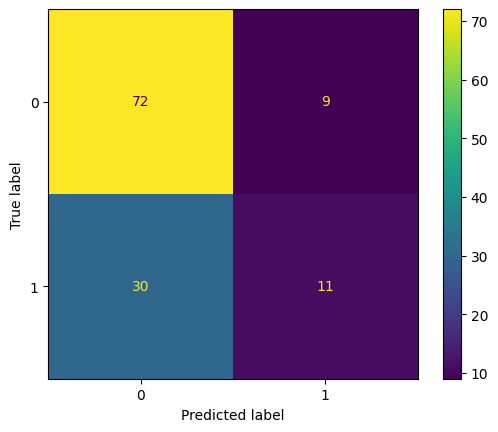

In [126]:
#compare real y-values with predicted values using confusion matrix and classification report 
cmboost = confusion_matrix(y_test, pred_test_clases)
dispboost = ConfusionMatrixDisplay(confusion_matrix=cmboost)
dispboost.plot()
print(classification_report(y_test, pred_test_clases))

In [173]:
#other evaluation metrics
#Sensitivity, specificity and ppv threshold dependent, the default threshold is 0,5 
#AUC and AP are threshold independent and therefore have to use the PROBABILITIES
sensitiviteit = cmboost[1,1]/(cmboost[1,0]+cmboost[1,1])
specificiteit = cmboost[0,0]/(cmboost[0,0]+cmboost[0,1])
ppv = cmboost[1,1]/(cmboost[1,1]+cmboost[0,1])
auc = roc_auc_score(y_test2, ypred)
average_precision = average_precision_score(y_test2, ypred)
print('sensitiviteit =', sensitiviteit, 'specificiteit =', specificiteit, 'ppv =', ppv, 'AUC =', auc, 'average_precision = ', average_precision)

sensitiviteit = 0.2682926829268293 specificiteit = 0.8888888888888888 ppv = 0.55 AUC = 0.6667647924639387 average_precision =  0.49148598486850104


2023-07-02 18:27:20,813	WARNING worker.py:1977 -- The node with node id: a6b6c46750883f16d8c0f86389e9b7d7ee5ad18537b5c2d5746afcb1 and address: 127.0.0.1 and node name: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.
(raylet) [2023-07-02 18:27:20,832 C 94656 35072] (raylet.exe) node_manager.cc:1039: [Timeout] Exiting because this node manager has mistakenly been marked as dead by the GCS: GCS failed to check the health of this node for 5 times. This is likely because the machine or raylet has become overloaded.
(raylet) *** StackTrace Information ***
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) unknown
(raylet) BaseThreadIn

Hyperparameter tuning 

In [56]:
#needed for ray tuner
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [115]:
import xgboost as xgb
from ray import tune
#code for hyperparameter tuning XgBoost model using the Ray Tuner 
#while using databricks you need to manualy add ray to the cluster in the compute window, while adding select from pypi
#define model

def tree(config):
    dtrain = xgb.DMatrix(x_train_sensor_static_up, label=y_train2_up)
    dval =  xgb.DMatrix(x_val_sensor_static, label=y_val2)
    results={}
    bst = xgb.train(
        config,
        dtrain,
        evals = [(dval, 'validation')],
        evals_result=results,
        verbose_eval=False,
       ) 
    accuracy = 1. - results["validation"]["error"][-1]
    auc = results["validation"]["auc"][-1]
    
    tune.report(mean_accuracy=accuracy, mean_auc = auc, done=True)
                
   
#define hyperparameters you would like to tune 
if __name__ == "__main__":
    config = { 
        "objective": "binary:logistic",
        "seed": 32,
        "eval_metric": ["auc", "error"],
        'max_depth': tune.randint(2,10),
        'min_child_weight' : tune.choice([1,2,3,4]),
        'gamma' : tune.choice([0, 1]),
        'eta' : tune.loguniform(1e-4, 1e-1),  
        'scale_pos_weight' : tune.choice([((len(y_train)-sum(y_train))/sum(y_train)),1]),
        
    }
    

    analysis = tune.run(
        tree,
        # You can add "gpu": 0.1 to allocate GPUs
        resources_per_trial={"cpu": 8},
        config=config,
        verbose=1,
        num_samples=200)   

(tree pid=54836) C:\arrow\cpp\src\arrow\filesystem\s3fs.cc:2598:  arrow::fs::FinalizeS3 was not called even though S3 was initialized.  This could lead to a segmentation fault at exit
2023-07-02 14:35:28,737	WARNING tune.py:976 -- Trial Runner checkpointing failed: Sync process failed: [WinError 32] Failed copying 'C:/Users/mbvan/ray_results/tree_2023-07-02_14-34-44/basic-variant-state-2023-07-02_14-34-44.json' to 'c:/Users/mbvan/ray_results/tree_2023-07-02_14-34-44/basic-variant-state-2023-07-02_14-34-44.json'. Detail: [Windows error 32] Het proces heeft geen toegang tot het bestand omdat het door een ander
proces wordt gebruikt.

2023-07-02 14:35:28,843	INFO tune.py:1002 -- Total run time: 43.91 seconds (43.57 seconds for the tuning loop).


In [116]:
#get best trial
best_trial = analysis.get_best_trial("mean_auc", "max")
best_accuracy = best_trial.metric_analysis["mean_auc"]["last"]


best_config = analysis.get_best_config("mean_auc", "max")
print(best_accuracy)
print(best_config)


0.7432814710042432
{'objective': 'binary:logistic', 'seed': 32, 'eval_metric': ['auc', 'error'], 'max_depth': 3, 'min_child_weight': 3, 'gamma': 1, 'eta': 0.07627635009594598, 'scale_pos_weight': 2.7244897959183674}


feature importance

In [ ]:
#feature importance, does not function well due to the many features caused by flattening the numpy array 
feature_important = boost.get_score(importance_type='weight')
feature_important 